# Question 1 – How many unique tennis players are there in the dataset?

---

## Overview

In this task, I aim to determine the **number of unique tennis players** present in the dataset, which spans two months (from `2024-02-01` to `2024-03-31`).  
Each day is stored in a separate folder with the following structure:

data/
tennis_data/
  20240201/
  data/
  raw/
 /raw_match_parquet
...

Each `raw_match_parquet/` folder contains around **3000 Parquet files**, resulting in **over 266,000 total files** — which poses serious performance challenges without optimization.

In [ ]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
from tqdm import tqdm
from threading import Lock
from concurrent.futures import ThreadPoolExecutor, as_completed

In [4]:
match_df = pd.read_parquet('../data/tennis_data/20240201/data/raw/raw_match_parquet')

In [5]:
match_df.head()

,match_id,name,slug,gender,user_count,residence,birthplace,height,weight,plays,turned_pro,current_prize,total_prize,player_id,current_rank,name_code,country,full_name
0,11998445,Auger-Aliassime F.,auger-aliassime-felix,M,23318.0,"Monte Carlo, Monaco","Montreal, Canada",1.93,87.0,right-handed,2017,218538.0,10166964.0,192013.0,30.0,AUG,Canada,"Auger-Aliassime, Felix"
1,11998446,Cobolli F.,flavio-cobolli,M,5995.0,Rome,"Florence, Italy",1.83,71.0,right-handed,None,178358.0,808536.0,273680.0,69.0,COB,Italy,Flavio Cobolli
2,11998447,Martínez P.,martinez-pedro,M,2621.0,"Valencia, Spain","Alzira, Spain",1.85,76.0,right-handed,2016,39448.0,2732689.0,77223.0,101.0,MAR,Spain,"Martinez, Pedro"
3,11998448,Muller A.,muller-alexandre,M,2443.0,France,"Poissy, France",1.83,73.0,right-handed,2014,106522.0,1178035.0,88992.0,81.0,MUL,France,"Muller, Alexandre"
4,11998449,Mayot H.,mayot-harold,M,1492.0,"Marly, France","Metz, France",1.78,78.0,right-handed,None,65798.0,424547.0,248846.0,132.0,MAY,France,"Mayot, Harold"


## Initial File Structure Analysis

Before diving into coding, I explored the structure of the files to understand what kind of data each contains.  
I found that **not all files contain player information**. Many of them do **not** have columns like `player_id`, `name`, or `full_name`.

---

## Initial Approach (Slow & Inefficient)

In my first attempt, I used a basic for-loop to iterate through all the Parquet files and extract `player_id` if available.

While functional, this method had major drawbacks:
- ❌ It took over **90 minutes** to complete.
- ❌ A large number of files had to be skipped due to missing `player_id`.

![Screenshot 2025-04-25 001757.png](<attachment:Screenshot 2025-04-25 001757.png>)

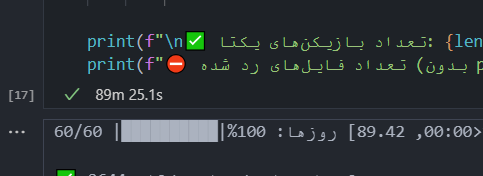


---

## Optimized Approach: Parallel Processing

To overcome the performance bottleneck, I implemented a **parallelized solution** using `concurrent.futures.ThreadPoolExecutor`.  
This enabled me to process multiple files **concurrently** and drastically reduce execution time.

### Benefits:
- Execution time dropped from 90 minutes to **~2 minutes**
- Smooth handling of invalid or incomplete files
- Progress tracking with `tqdm`

In [ ]:
base_dir = '../data/tennis_data'
all_player_ids = set()
skipped_files = 0

In [7]:
lock = Lock()

def process_file(file_path):
    global skipped_files
    try:
        table = pq.read_table(file_path)
        if 'player_id' in table.schema.names:
            column = table['player_id']
            player_ids = set([pid for pid in column.to_pylist() if pid is not None])
            return player_ids, 0
        else:
            return set(), 1
    except:
        return set(), 1

In [8]:
all_file_paths = []
day_folders = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])

for day in day_folders:
    match_dir = os.path.join(base_dir, day, 'data', 'raw', 'raw_match_parquet')
    if os.path.exists(match_dir):
        files = [f for f in os.listdir(match_dir) if f.endswith('.parquet')]
        full_paths = [os.path.join(match_dir, f) for f in files]
        all_file_paths.extend(full_paths)



with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_file, all_file_paths), total=len(all_file_paths)))


for player_ids, skipped in results:
    all_player_ids.update(player_ids)
    skipped_files += skipped


print(f"✅ تعداد بازیکن‌های یکتا: {len(all_player_ids)}")
print(f"⛔ تعداد فایل‌های رد شده (بدون player_id یا با ارور): {skipped_files}")

100%|██████████| 316802/316802 [02:12<00:00, 2394.87it/s]

✅ تعداد بازیکن‌های یکتا: 2644
⛔ تعداد فایل‌های رد شده (بدون player_id یا با ارور): 266989


In [ ]:
pd.Series(list(all_player_ids)).to_csv("..../outputs/reports/player_ids.csv", index=False)


---

## Summary

In this question, we learned:

- It's crucial to explore file structure before heavy data processing.
- Naively iterating through hundreds of thousands of files is impractical.
- **Parallelization** provides a massive speed-up for I/O-heavy tasks.
- Only a small portion of files contained valid `player_id`, the rest were discarded safely.
